## Importing the required libraries from and using yfinance to fetch past stock data


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
def stock_data(tickers,start_date,end_date):
    data=yf.download(tickers,start=start_date,end=end_date)['Close']
    return data

# Prompt user for input
user_tickers=input("Enter stock tickers separated by commas (e.g., RELIANCE.NS,TCS.NS) or press Enter for default: ").split(',')
start_date=input("Enter the start date (YYYY-MM-DD) or press Enter for default (2023-01-01): ")
end_date=input("Enter the end date (YYYY-MM-DD) or press Enter for default (2025-01-01): ")

# Set defaults if input is incomplete
default_tickers=['RELIANCE.NS','TCS.NS','INFY.NS','HDFCBANK.NS','ITC.NS']


default_start_date='2023-01-01'
default_end_date='2025-01-01'

tickers=user_tickers if any(user_tickers) else default_tickers
start_date=start_date if start_date else default_start_date
end_date=end_date if end_date else default_end_date
stocks=tickers
data=stock_data(tickers,start_date,end_date)



Enter stock tickers separated by commas (e.g., RELIANCE.NS,TCS.NS) or press Enter for default: TCS.NS,HCLTECH.NS,INFY.NS,SBIN.NS,JSWSTEEL.NS
Enter the start date (YYYY-MM-DD) or press Enter for default (2023-01-01): 2023-01-01
Enter the end date (YYYY-MM-DD) or press Enter for default (2025-01-01): 2025-01-01


[*********************100%***********************]  5 of 5 completed


##Calculating log returns and using risk free rate of 6%


In [ ]:
log_returns=np.log(data / data.shift(1)).dropna()
mean_returns=log_returns.mean()
cov_matrix=log_returns.cov()
risk_free_rate=0.060

##Plotting Q-Q plot which helps us visualise the  log returns against a normal distribution

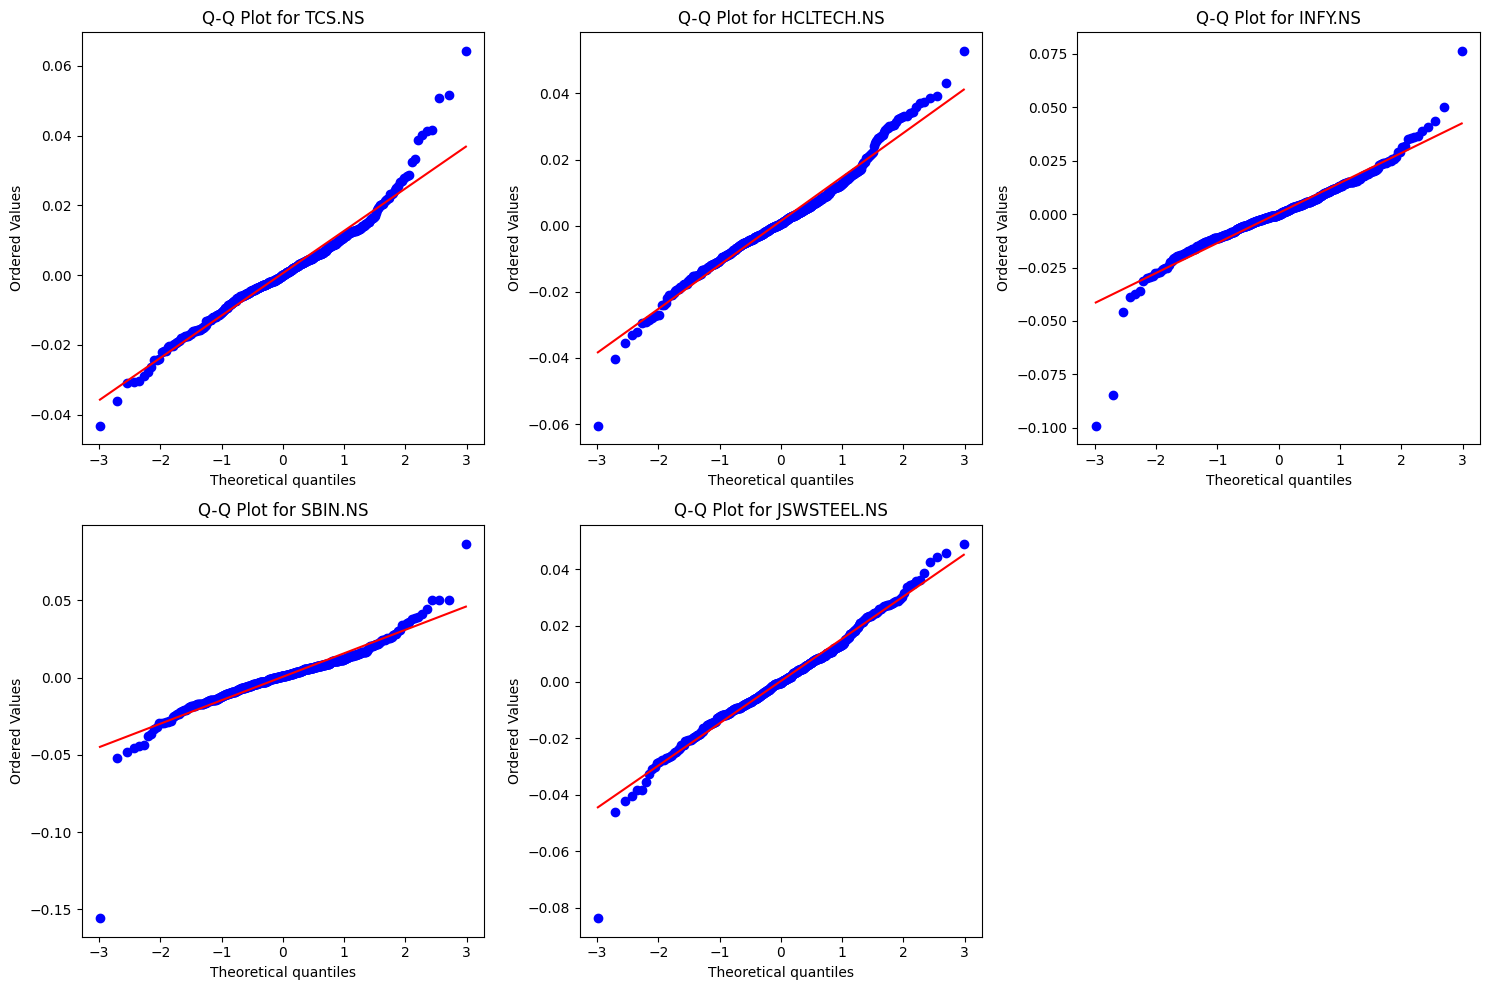

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
log_returns = np.log(data / data.shift(1)).dropna()

# Step 2: Create Q-Q plots for each stock
plt.figure(figsize=(15, 10))
for i, stock in enumerate(stocks):
    plt.subplot(2, 3, i + 1)
    stats.probplot(log_returns[stock], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot for {stock}")

plt.tight_layout()
plt.show()

##Creating a 2D matrix containing 100000 entries. 4 columns being return, stddev,sharpe and index. We will use this matrix to choose the optimal set

In [ ]:
num_portfolios = 100000
results = np.zeros((4, num_portfolios))
weights_record = []

##Monte Carlo simulation on a sample size of 10,000,000

In [ ]:
for i in range(num_portfolios):
    weights = np.random.random(len(stocks))
    weights /= np.sum(weights)
    weights_record.append(weights)
    # Expected return and volatility
    portfolio_return = np.sum(weights * mean_returns) * 252
    portfolio_stddev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252) #taking dot product of weight(transpose)*cov*weights
    # Sharpe ratio
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_stddev
    # Store results
    results[0, i] = portfolio_return
    results[1, i] = portfolio_stddev
    results[2, i] = sharpe_ratio
    results[3, i] = i

##Storing the indices of the result row with minimum volatality and maximum sharpe.

In [ ]:
min_vol_idx=results[1].argmin()
max_sharpe_idx=results[1].argmax()
max_sharpe_portfolio=results[:,max_sharpe_idx]
min_vol_portfolio=results[:,min_vol_idx]

##Plotting the Efficient Frontier

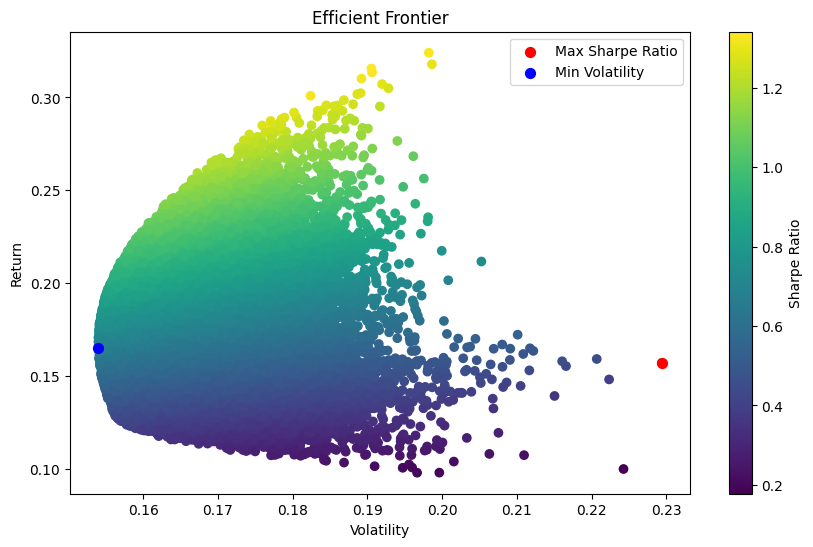

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(max_sharpe_portfolio[1], max_sharpe_portfolio[0], color='red', s=50, label='Max Sharpe Ratio')
plt.scatter(min_vol_portfolio[1], min_vol_portfolio[0], color='blue', s=50, label='Min Volatility')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.title('Efficient Frontier')
plt.legend()
plt.show()

##Printing the corresponding weights

In [ ]:
print("Max Sharpe Ratio Portfolio Weights:")
print(pd.Series(weights_record[int(max_sharpe_portfolio[3])],index=stocks))
print("\nMin Volatility Portfolio Weights:")
print(pd.Series(weights_record[int(min_vol_portfolio[3])],index=stocks))
last_prices = data.iloc[-1]
percentage_changes = (data.iloc[-2] - data.iloc[1]) / data.iloc[1] * 100
average_growth = percentage_changes.mean()

projected_prices = last_prices * (1 + percentage_changes / 100)


Max Sharpe Ratio Portfolio Weights:
TCS.NS         0.040426
HCLTECH.NS     0.053635
INFY.NS        0.042401
SBIN.NS        0.854020
JSWSTEEL.NS    0.009518
dtype: float64

Min Volatility Portfolio Weights:
TCS.NS         0.161206
HCLTECH.NS     0.055452
INFY.NS        0.224592
SBIN.NS        0.195448
JSWSTEEL.NS    0.363302
dtype: float64


# Taking an initial investment of 10,000,000. We are calculating the net returns obtained on the investment at the year end.

In [ ]:
initial_investment=1000000
max_sharpe_weights=weights_record[int(max_sharpe_portfolio[3])]
min_vol_weights=weights_record[int(min_vol_portfolio[3])]
max_sharpe_investment = initial_investment*max_sharpe_weights
min_vol_investment = initial_investment*min_vol_weights


max_sharpe_shares =max_sharpe_investment/last_prices
min_vol_shares=min_vol_investment/last_prices


portfolio_value_end_max_sharpe=np.sum(max_sharpe_shares*projected_prices)
portfolio_value_end_min_vol = np.sum(min_vol_shares*projected_prices)


profit_percentage_max_sharpe = ((portfolio_value_end_max_sharpe - initial_investment) / initial_investment) * 100
profit_percentage_min_vol = ((portfolio_value_end_min_vol - initial_investment) / initial_investment) * 100


print("Max Sharpe Ratio Portfolio Weights:")
print(max_sharpe_weights)
print(f"Projected portfolio value at year-end for Max Sharpe Ratio Portfolio: ₹{portfolio_value_end_max_sharpe:.2f}")
print(f"Projected profit percentage for Max Sharpe Ratio Portfolio by year-end: {profit_percentage_max_sharpe:.2f}%")

print("\nMin Volatility Portfolio Weights:")
print(min_vol_weights)
print(f"Projected portfolio value at year-end for Min Volatility Portfolio: ₹{portfolio_value_end_min_vol:.2f}")
print(f"Projected profit percentage for Min Volatility Portfolio by year-end: {profit_percentage_min_vol:.2f}%")

Max Sharpe Ratio Portfolio Weights:
[0.04042599 0.05363491 0.04240114 0.85402008 0.00951788]
Projected portfolio value at year-end for Max Sharpe Ratio Portfolio: ₹1354002.32
Projected profit percentage for Max Sharpe Ratio Portfolio by year-end: 35.40%

Min Volatility Portfolio Weights:
[0.16120565 0.055452   0.22459183 0.19544836 0.36330216]
Projected portfolio value at year-end for Min Volatility Portfolio: ₹1401420.50
Projected profit percentage for Min Volatility Portfolio by year-end: 40.14%
